In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
#import xgcm
from datetime import timedelta
import calendar

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40733/status,
Dashboard: /proxy/40733/status,Workers: 6
Total threads: 24,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37907,Workers: 6
Dashboard: /proxy/40733/status,Total threads: 24
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:39819,Total threads: 4
Dashboard: /proxy/45417/status,Memory: 21.33 GiB
Nanny: tcp://127.0.0.1:43411,


In [4]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'

In [5]:
basal_gade = 'accessom2-GPC021'

basal_gade_woa = 'accessom2-GPC023'

gade_icb_woa = 'accessom2-GPC026'

start_time='1900-01-01'
end_time='1901-01-01'

lat_slice  = slice(-80,-59)

lat_slice = slice(-90,-59)
lon_slice = slice(-280,80)
isobath_depth = 1000

In [6]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC023/accessom2-GPC023/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC026/accessom2-GPC026/']

cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC023


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC026


0it [00:00, ?it/s]


0

In [7]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [8]:
start_time='1909-01-01'
end_time='1910-01-01'

# Get grid info
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

#Import seaice
hi_con = cc.querying.getvar(control, 'hi_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_con = cc.querying.getvar(control, 'aice_m', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

hi_gade = cc.querying.getvar(basal_gade_woa, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_gade = cc.querying.getvar(basal_gade_woa, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

hi_gade_icb = cc.querying.getvar(gade_icb_woa, 'hi_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
aice_gade_icb = cc.querying.getvar(gade_icb_woa, 'aice_m', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

In [9]:
# Rename coordinates
# t-grid
aice_con.coords['ni'] = area_t['xt_ocean'].values
aice_con.coords['nj'] = area_t['yt_ocean'].values
aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_con.coords['ni'] = area_t['xt_ocean'].values
hi_con.coords['nj'] = area_t['yt_ocean'].values
hi_con = hi_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_gade.coords['ni'] = area_t['xt_ocean'].values
aice_gade.coords['nj'] = area_t['yt_ocean'].values
aice_gade = aice_gade.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_gade.coords['ni'] = area_t['xt_ocean'].values
hi_gade.coords['nj'] = area_t['yt_ocean'].values
hi_gade = hi_gade.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_gade_icb.coords['ni'] = area_t['xt_ocean'].values
aice_gade_icb.coords['nj'] = area_t['yt_ocean'].values
aice_gade_icb = aice_gade_icb.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
hi_gade_icb.coords['ni'] = area_t['xt_ocean'].values
hi_gade_icb.coords['nj'] = area_t['yt_ocean'].values
hi_gade_icb = hi_gade_icb.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [10]:
# Move time 12 hr forward to make sure it is in the correct month
aice_con['time'] = aice_con.time.to_pandas() - timedelta(hours = 12)
hi_con['time']   = hi_con.time.to_pandas() - timedelta(hours = 12)

aice_gade['time'] = aice_gade.time.to_pandas() - timedelta(hours = 12)
hi_gade['time']   = hi_gade.time.to_pandas() - timedelta(hours = 12)

aice_gade_icb['time'] = aice_gade_icb.time.to_pandas() - timedelta(hours = 12)
hi_gade_icb['time']   = hi_gade_icb.time.to_pandas() - timedelta(hours = 12)

In [11]:
hi_con = hi_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_con = aice_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

hi_gade = hi_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_gade = aice_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

hi_gade_icb = hi_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
aice_gade_icb = aice_gade_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

In [12]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con = aice_con * area_t * hi_con * 1e-9

vi_gade = aice_gade * area_t * hi_gade * 1e-9

vi_gade_icb = aice_gade_icb * area_t * hi_gade_icb * 1e-9

In [13]:
# time averages

hi_con_avet = hi_con.mean('time').load()
aice_con_avet = aice_con.mean('time').load()

hi_gade_avet = hi_gade.mean('time').load()
aice_gade_avet = aice_gade.mean('time').load()

hi_gade_icb_avet = hi_gade_icb.mean('time').load()
aice_gade_icb_avet = aice_gade_icb.mean('time').load()

In [14]:
# monthly climatologies

hi_con_mm = hi_con.groupby('time.month').mean('time').load()
aice_con_mm = aice_con.groupby('time.month').mean('time').load()

hi_gade_mm = hi_gade.groupby('time.month').mean('time').load()
aice_gade_mm = aice_gade.groupby('time.month').mean('time').load()

hi_gade_icb_mm = hi_gade_icb.groupby('time.month').mean('time').load()
aice_gade_icb_mm = aice_gade_icb.groupby('time.month').mean('time').load()

In [15]:
# Calculate sea ice volume, convert to km^3 and rename dataarray
vi_con_avet = aice_con_avet * area_t * hi_con_avet * 1e-9

vi_gade_avet = aice_gade_avet * area_t * hi_gade_avet * 1e-9

vi_gade_icb_avet = aice_gade_icb_avet * area_t * hi_gade_icb_avet * 1e-9

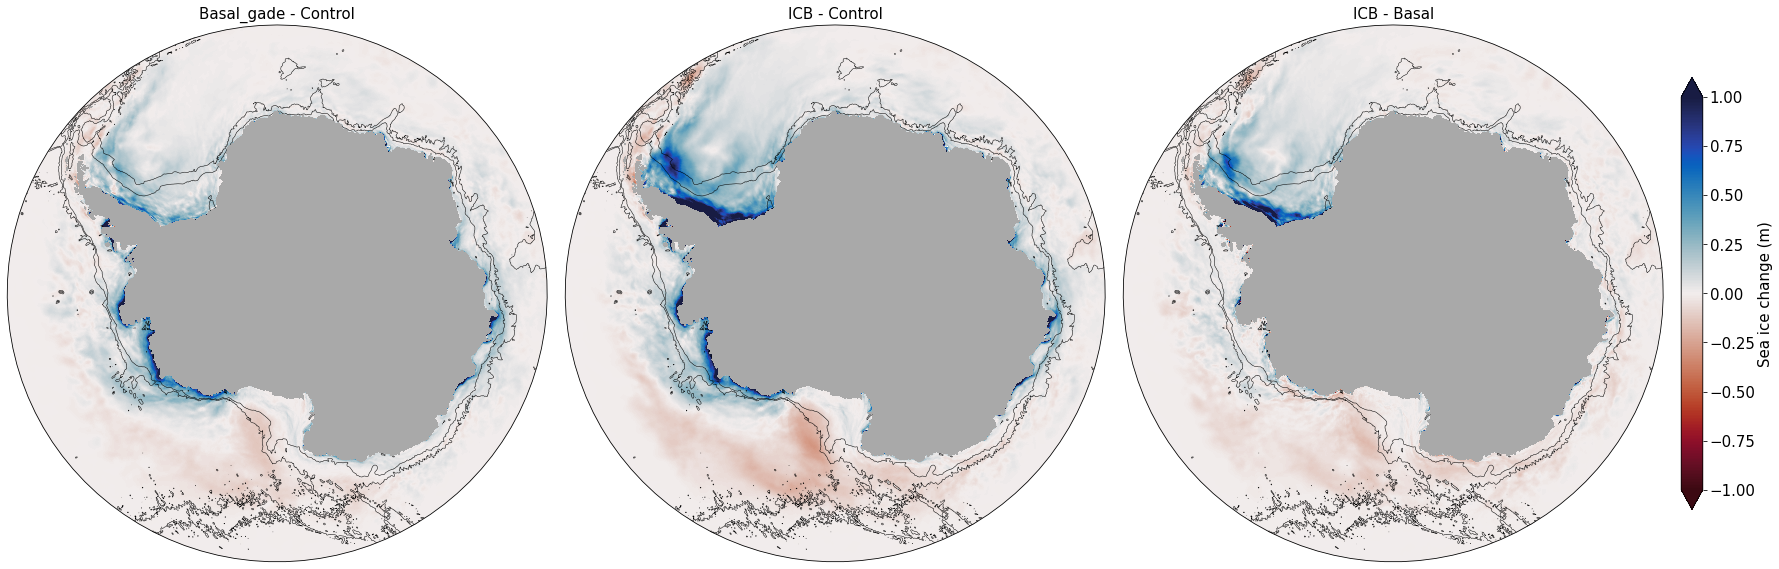

In [25]:
scale_max = 1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)

# Basal
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_gade_avet - hi_con_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_gade_icb_avet - hi_con_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Basal
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, hi_gade_icb_avet - hi_gade_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice change (m)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

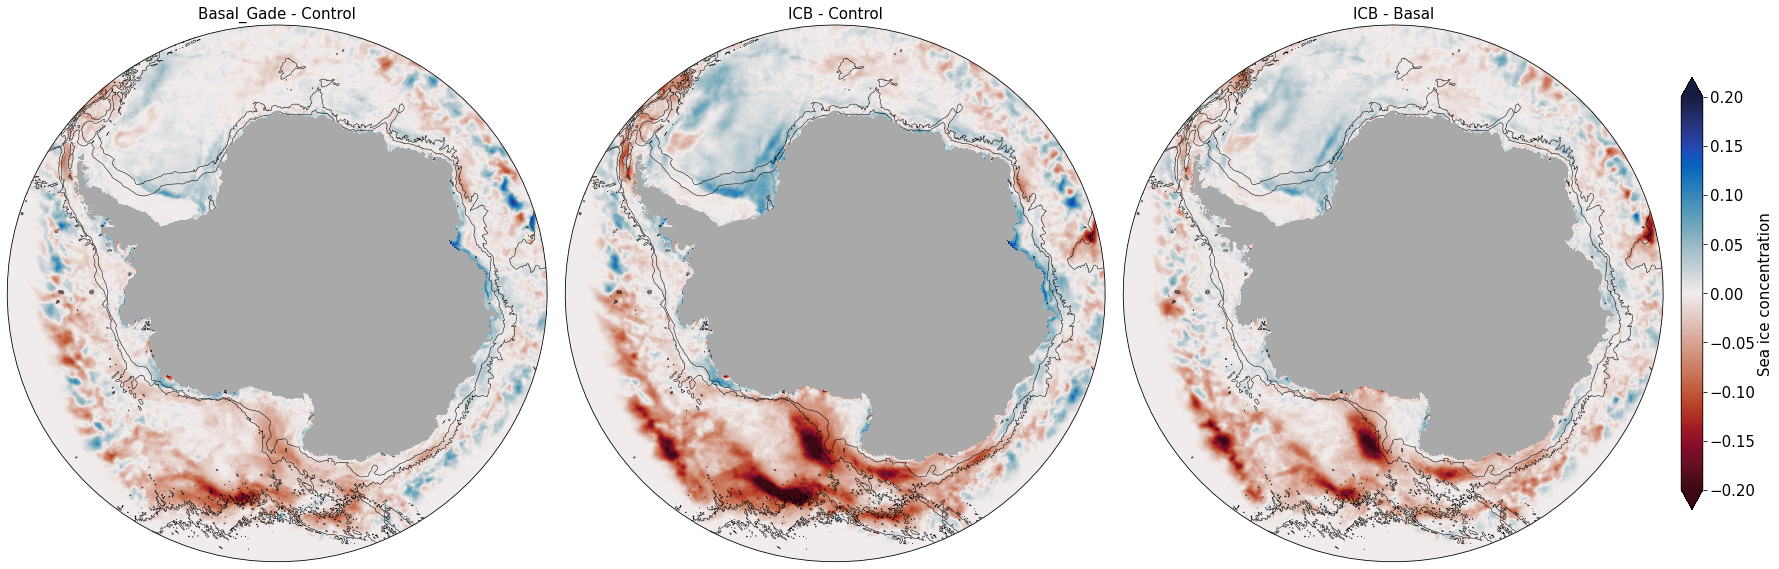

In [17]:
scale_max = 0.2

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)

# Basal
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_gade_avet - aice_con_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_gade_icb_avet - aice_con_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Basal
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_gade_icb_avet - aice_gade_avet, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - Basal',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice concentration',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [22]:
#Time series

In [18]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [19]:
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
vi_con_shelf  = vi_con * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_con_shelf = vi_con_shelf.load()

vi_gade_shelf  = vi_gade * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_gade_shelf = vi_gade_shelf.load()

vi_gade_icb_shelf = vi_gade_icb * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
vi_gade_icb_shelf = vi_gade_icb_shelf.load()

In [20]:
vi_con_shelf_cpolar  = vi_con.sum('xt_ocean').sum('yt_ocean')
vi_gade_shelf_cpolar = vi_gade.sum('xt_ocean').sum('yt_ocean')
vi_gade_icb_shelf_cpolar = vi_gade_icb.sum('xt_ocean').sum('yt_ocean')

In [21]:
vi_con_shelf_cpolar_a = vi_con_shelf_cpolar.mean('time')
vi_gade_shelf_cpolar_a = vi_gade_shelf_cpolar.mean('time')
vi_gade_icb_shelf_cpolar_a = vi_gade_icb_shelf_cpolar.mean('time')

In [22]:
#Plotting

In [23]:
# Month labels
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Panel labels
panel_name = ['A', 'B', 'C', 'D', 'E', 'F']
# Font size
plt.rcParams['font.size'] = 14
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

(0.0, 84.0)

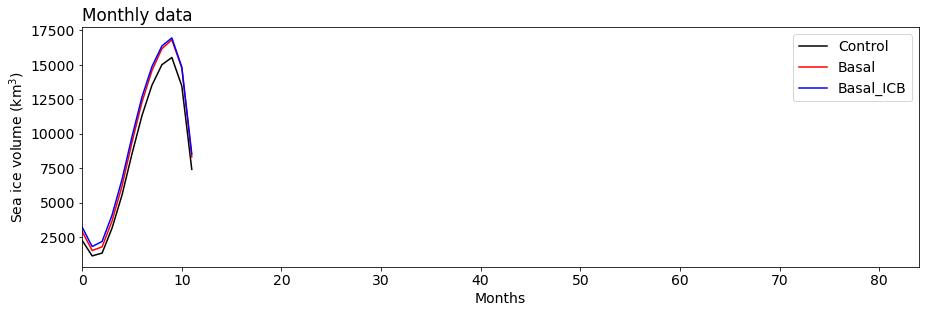

In [24]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Monthly data', loc='left')
plt.plot(vi_con_shelf_cpolar, color='k', label='Control')
plt.plot(vi_gade_shelf_cpolar, color='red', label='Basal')
plt.plot(vi_gade_icb_shelf_cpolar, color='blue', label='Basal_ICB')

plt.legend()
plt.xlabel('Months')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,84)

(0.0, 5.0)

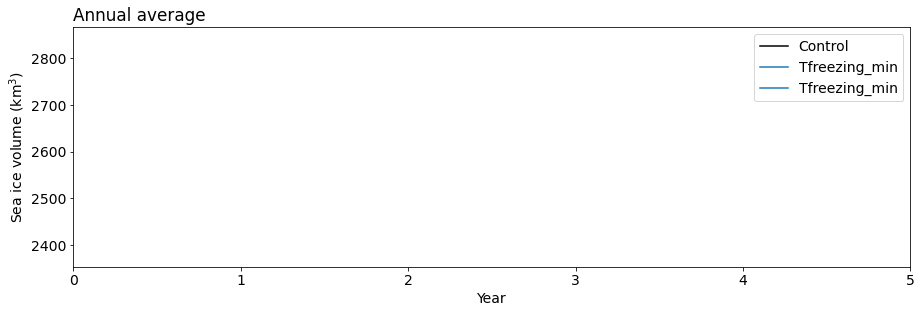

In [30]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual average', loc='left')
plt.plot(vi_con_shelf_cpolar_a, color='k', label='Control')
plt.plot(vi_Tfreezing_min_calv_2_shelf_cpolar_a, color='C0', label='Tfreezing_min')
plt.plot(vi_basal_gade_shelf_cpolar_a, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

NameError: name 'vi_con_shelf_cpolar_sum' is not defined

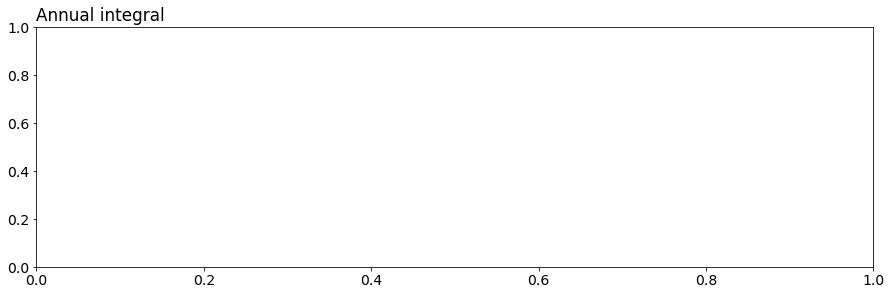

In [31]:
fig = plt.figure(figsize=(15,15))

plt.subplot(311)
plt.title('Annual integral', loc='left')
plt.plot(vi_con_shelf_cpolar_sum, color='k', label='Control')
plt.plot(vi_Tfreezing_min_shelf_cpolar_sum, color='C0', label='Tfreezing_min')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sea ice volume (km$^3$)')
plt.xlim(0,5)

## Cover area

**BUG**: this is the extent (not area), with a threshold of 0%

The correct calculation is in the "sea ice extent" section below.

In [32]:
import numpy.ma as ma

In [33]:
area_t = area_t.sel(yt_ocean=lat_slice)

aa = ma.masked_where(hi_con==0,hi_con)  ## TODO: fix this
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_con = hi_con[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_con[tt] = cover_area[tt].sum()

In [34]:
aa = ma.masked_where(hi_Tfreezing_min_calv_2==0,hi_Tfreezing_min_calv_2)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_Tfreezing_min_calv_2 = hi_Tfreezing_min_calv_2[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_Tfreezing_min_calv_2[tt] = cover_area[tt].sum()

In [35]:
aa = ma.masked_where(hi_basal_gade==0,hi_basal_gade)
cover_area = aa * area_t
bb = np.where(cover_area!=cover_area)
cover_area[bb] = 0
cover_area_sum_basal_gade = hi_basal_gade[:,0,0]*0
for tt in range(cover_area.shape[0]):
    cover_area_sum_basal_gade[tt] = cover_area[tt].sum()

In [36]:
obs = [7,3.5,3.2,5.5,8.25,12,15,17.2,18,18.5,17.5,13.5]
obs2 = [3.5,2,3.5,6,9,12,14.5,16,15.5,15,12,7]

Text(0.5, 1.0, 'Sea ice Area over the Antarctica')

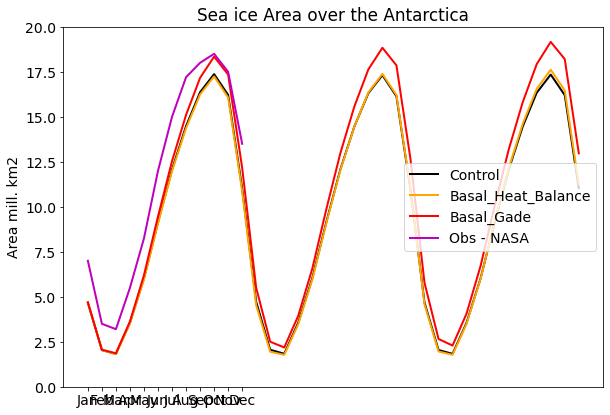

In [37]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(cover_area_sum_con[0:]/1e12,lw=2,color='k',label="Control")
ax.plot(cover_area_sum_Tfreezing_min_calv_2[0:]/1e12,lw=2,color='orange',label='Basal_Heat_Balance')
ax.plot(cover_area_sum_basal_gade[0:]/1e12,lw=2,color='red',label='Basal_Gade')
ax.plot(obs,lw=2,color='m',label="Obs - NASA")
#ax.plot(obs2,lw=2,color='r',label="Obs - EUMETSAT")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.ylabel("Area mill. km2")
#plt.xlabel("Months")
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.ylim(ymin=0,ymax=20)
plt.title("Sea ice Area over the Antarctica")

## Sea ice extent

based on https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/ice_timeseries/ice_timeseries.ipynb

In [38]:
import xesmf
import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm_notebook

In [39]:
timerange = slice(pd.to_datetime('1990-05-01', format='%Y-%m-%d'),
                  pd.to_datetime('1991-04-30', format='%Y-%m-%d'))  # RYF: 1 May 1990 - 30 April 1991

In [40]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
    df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    print(df)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [41]:
# Specify paths to observational data

ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsExtNHFileList = glob.glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob.glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsExtNHFileList.sort()
obsExtSHFileList.sort()

In [42]:
NH_obs = loadObsExt(obsExtNHFileList)
NH_obs_mm = NH_obs.sel(time=timerange).groupby('time.month').mean('time', skipna=True)
SH_obs = loadObsExt(obsExtSHFileList)
SH_obs_mm = SH_obs.sel(time=timerange).groupby('time.month').mean('time', skipna=True)
SH_extent_clim_obs = SH_climatology_obs.extent

    year  mo      data-type   region  extent   area       time
0   1979   1        Goddard        N   15.41  12.41 1979-01-01
1   1980   1        Goddard        N   14.86  11.94 1980-01-01
2   1981   1        Goddard        N   14.91  11.91 1981-01-01
3   1982   1        Goddard        N   15.18  12.19 1982-01-01
4   1983   1        Goddard        N   14.94  12.01 1983-01-01
..   ...  ..            ...      ...     ...    ...        ...
39  2017  12        Goddard        N   11.74  10.26 2017-12-01
40  2018  12        Goddard        N   11.86  10.45 2018-12-01
41  2019  12        Goddard        N   11.90  10.52 2019-12-01
42  2020  12        Goddard        N   11.73  10.16 2020-12-01
43  2021  12        Goddard        N   12.15  10.74 2021-12-01

[524 rows x 7 columns]
    year  mo      data-type   region  extent  area       time
0   1979   1        Goddard        S    5.40  3.47 1979-01-01
1   1980   1        Goddard        S    4.56  3.08 1980-01-01
2   1981   1        Goddard       

In [66]:
area_t = area_t.sel(yt_ocean=lat_slice)
extent_con_mm = xr.where(aice_con_mm > 0.15, area_t, 0.).sum('xt_ocean').sum('yt_ocean')
extent_Tfreezing_min_calv_2_mm = xr.where(aice_Tfreezing_min_calv_2_mm > 0.15, area_t, 0.).sum('xt_ocean').sum('yt_ocean')
extent_basal_gade_mm = xr.where(aice_basal_gade_mm > 0.15, area_t, 0.).sum('xt_ocean').sum('yt_ocean')

Text(0.5, 1.0, 'Antarctic sea ice extent')

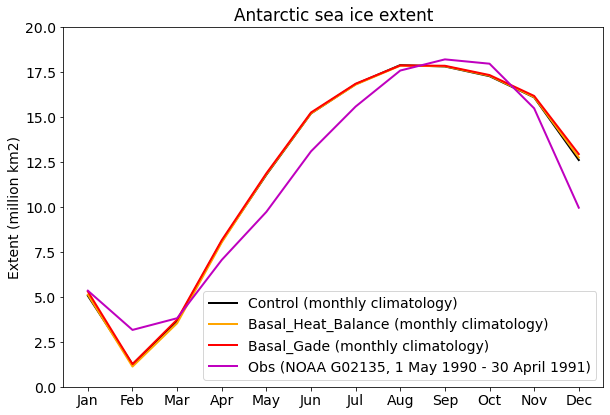

In [85]:
fig  = plt.figure(1, figsize = (25,5))
ax = fig.add_axes([0.0, 0.0, 0.3, 1])

ax.plot(extent_con_mm/1e12,lw=2,color='k',label="Control (monthly climatology)")
ax.plot(extent_Tfreezing_min_calv_2_mm/1e12,lw=2,color='orange',label='Basal_Heat_Balance (monthly climatology)')
ax.plot(extent_basal_gade_mm/1e12,lw=2,color='red',label='Basal_Gade (monthly climatology)')
ax.plot(SH_obs_mm.extent/1e12,lw=2,color='m',label="Obs (NOAA G02135, 1 May 1990 - 30 April 1991)")
#ax.plot(obs2,lw=2,color='r',label="Obs - EUMETSAT")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.ylabel("Extent (million km2)")
#plt.xlabel("Months")
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.ylim(ymin=0,ymax=20)
plt.title("Antarctic sea ice extent")

## Regridders
based on https://nbviewer.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders

see https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html and https://xesmf.readthedocs.io

In [52]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf_cycle3/output488/ocean/ocean-3d-temp-1-daily-mean-ym_1958_01.nc')\
                    .rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        try:
            return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})
        except ValueError:
            return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean'})
    return outf

In [53]:
obsfile_SH = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
regrid_SHobs_to_01 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_01.nc')

## Sea ice concentration
based on https://nbviewer.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb

In [45]:
def get_sic_obs(pattern, path='/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3', # from http://nsidc.org/data/G02202
                variable='goddard_merged_seaice_conc_monthly', timerange=timerange): 
    '''
    Return a dataarray from the nc files in path/pattern.
    '''
    dataarrays = []
    files = glob.glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='opening files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1)) #, np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time and select timerange
    dataarray = dataarray.sortby('time').sel(time=timerange)

    return dataarray

In [46]:
def obs_mm(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

In [47]:
obs_SH = get_sic_obs('south/monthly/*.nc', timerange=timerange)

opening files:   0%|          | 0/493 [00:00<?, ?it/s]

In [48]:
obs_SH_mm = obs_mm(obs_SH)  # monthly climatologies
obs_SH_avet = obs_SH.mean('time', skipna=True)  # mean for all data

In [54]:
obs_SH_mm_regrid = regrid_SHobs_to_01(obs_SH_mm)
obs_SH_avet_regrid = regrid_SHobs_to_01(obs_SH_avet)

## plot SIC anomalies relative to obs (average over all months)

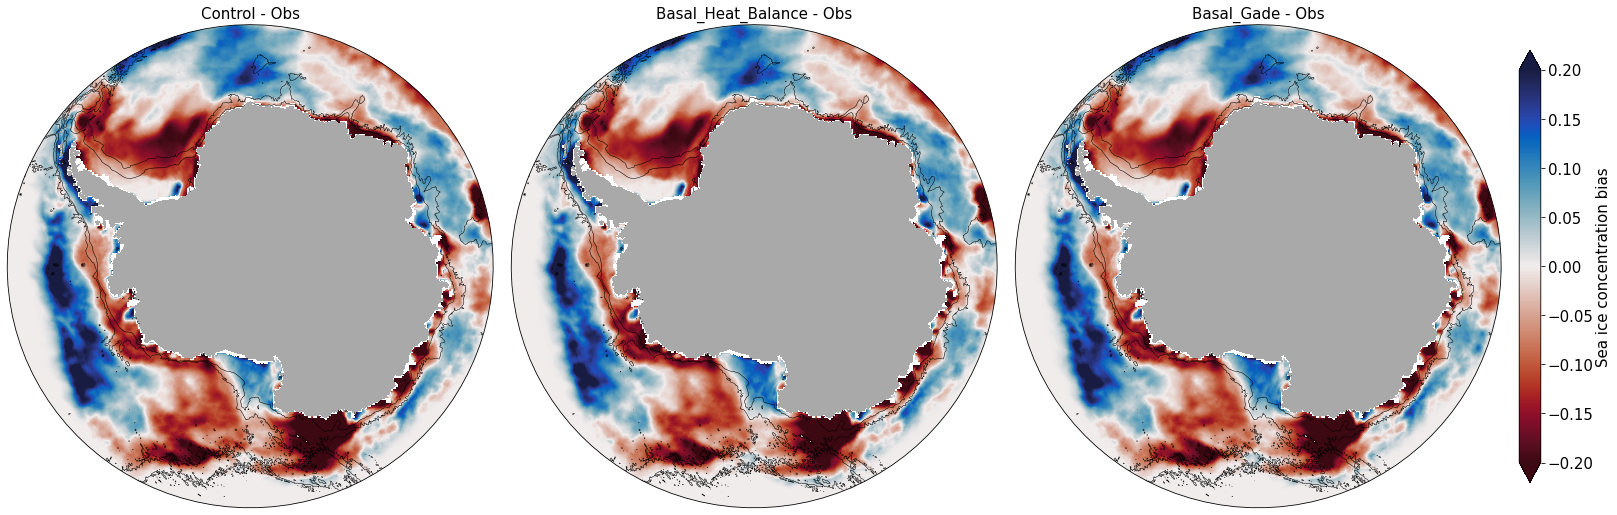

In [55]:
scale_max = 0.2
fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_con_avet - obs_SH_avet_regrid, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.28, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_Tfreezing_min_calv_2_avet - obs_SH_avet_regrid, norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Heat_Balance - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Gade
ax = fig.add_axes([0.56, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, (aice_basal_gade_avet - obs_SH_avet_regrid), norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.84, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Sea ice concentration bias',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

## plot SIC anomalies relative to obs (climatology over one month)

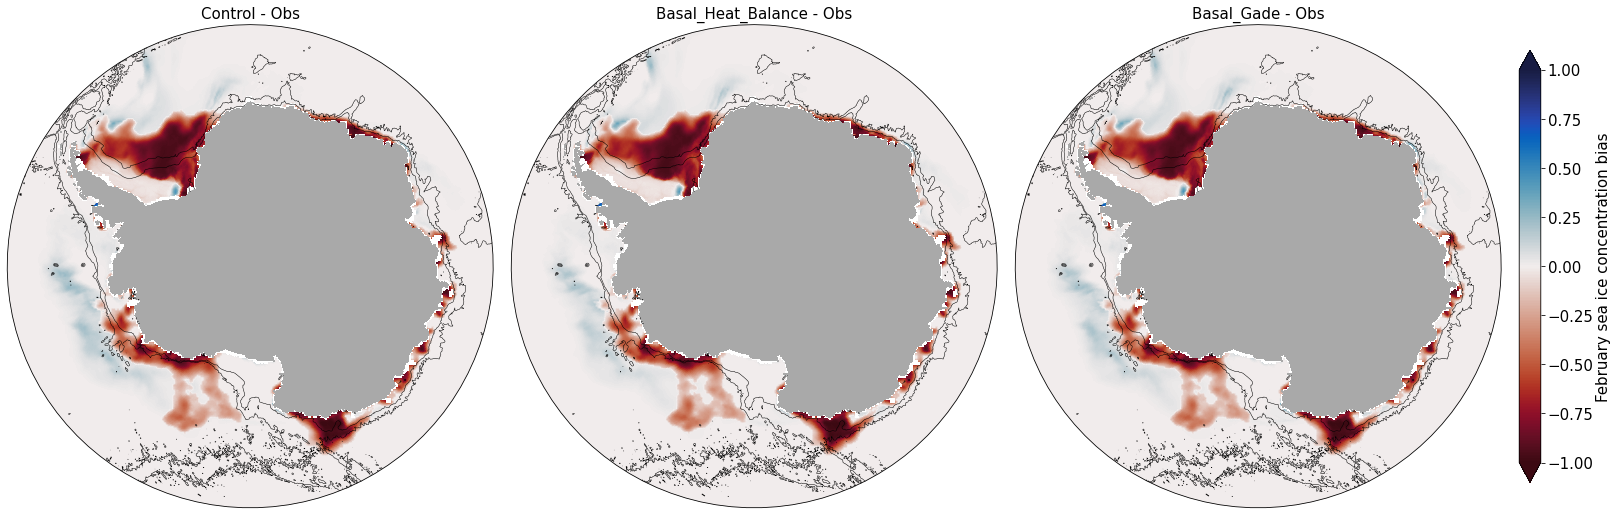

In [56]:
mo = 2 # Feb=2

scale_max = 1
fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_con_mm.sel(month=mo) - obs_SH_mm_regrid.sel(month=mo), norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.28, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
## plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, aice_Tfreezing_min_calv_2_mm.sel(month=mo) - obs_SH_mm_regrid.sel(month=mo), norm=norm,  
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Heat_Balance - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Gade
ax = fig.add_axes([0.56, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(hi_con.xt_ocean, hi_con.yt_ocean, (aice_basal_gade_mm.sel(month=mo) - obs_SH_mm_regrid.sel(month=mo)), norm = norm, 
                   cmap = cmocean.balance_r, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.84, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(' '.join([calendar.month_name[mo], r'sea ice concentration bias']),fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)